In [63]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots

plt.style.use('ggplot')

In [14]:
desktop = Path.home() / 'Desktop'

filename = desktop / 'drafts.csv'
df = pd.read_csv(filename)

In [15]:
first, last, cnt = df.draft_year.min(), df.draft_year.max(), df.draft_year.nunique()
print(f'Data for {cnt} drafts between {first} and {last}')

Data for 45 drafts between 1977 and 2021


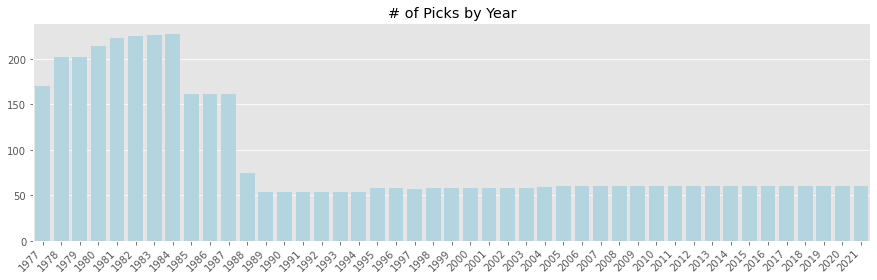

In [5]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.countplot(data=df, x='draft_year', color='lightblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set(title='# of Picks by Year', xlabel='', ylabel='')
# ax.xaxis.set_ticks_position('none')
plt.show()

What's going on with those number of picks per year?

Well apparently the NBA draft was initially 7 rounds! Apparently you could revamp a whole new starting squad in one year back then!

Let's get rid of the years with those extra rounds.

# Cleaning

In [16]:
mask = df.pick_overall.isna()
df.loc[mask, ]

,ranker,pick_overall,team_id,player,college_name,seasons,g,mp,pts,trb,...,mp_per_g,pts_per_g,trb_per_g,ast_per_g,ws,ws_per_48,bpm,vorp,draft_year,url
2940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,1
2965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,1


In [17]:
df = backup.copy()
mask = (df.loc[:, 'draft_year'] >= 1990) & ~df.pick_overall.isna()
df = df.loc[mask, :]
picks_per_year = df.groupby('draft_year').pick_overall.count().rename('draft_year_picks')
df.loc[:, 'draft_year_picks'] = (df.loc[:, ['draft_year']]
                                 .merge(picks_per_year, how='left', left_on='draft_year', right_index=True)
                                 .draft_year_picks)
df.loc[:, 'draft_round'] = (df.pick_overall.floordiv(df.draft_year_picks.floordiv(2)).add(1) > 1) + 1
df.pick_overall = df.pick_overall.astype(int)
df = df.set_index(['draft_year', 'pick_overall'])

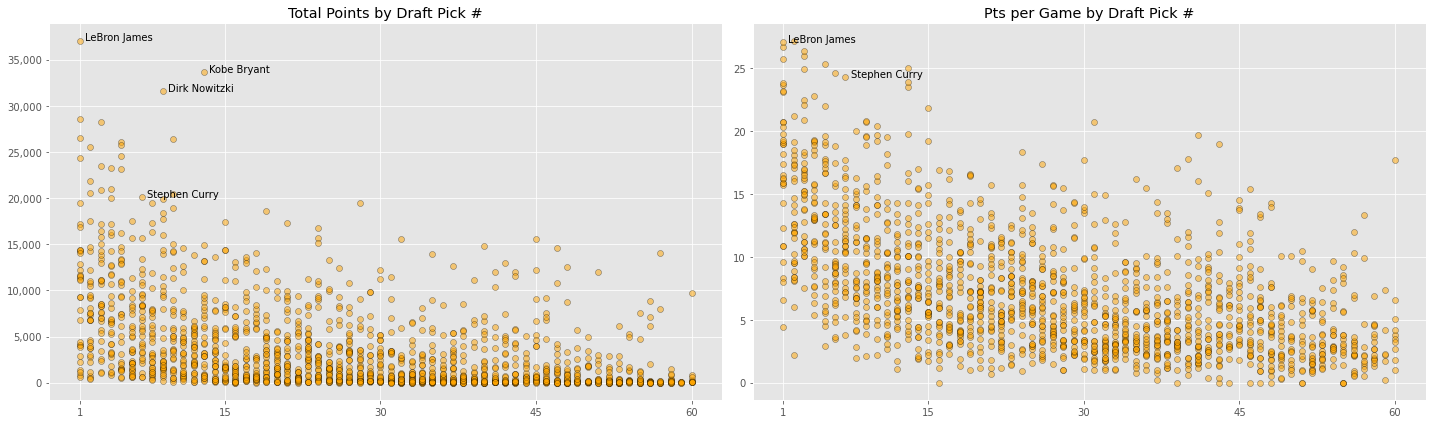

In [244]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
xticks = (1, 15, 30, 45, 60)

ax = axes[0]
bball_scatter_style = dict(c='orange', edgecolors='black', alpha=0.5)
ax.scatter(df.index.get_level_values('pick_overall'), df.pts, **bball_scatter_style)
ax.set_xticks(xticks)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set(title='Total Points by Draft Pick #')


top_scores = (df.nlargest(3, 'pts')
              .loc[:, ['player', 'pts']])
for idx, row in top_scores.iterrows():
    draft_year, pick_overall, player, pts = (*idx, *row)
    xy = (pick_overall, pts)
    xytext = (xy[0] + 0.5, xy[1])
    params = dict(xy=xy, xytext=xytext)
    ax.annotate(player, **params)

mask = df.loc[:, 'player'].str.contains('Stephen Curry')
draft_year, pick_overall, player, pts = (df.loc[mask, :].reset_index()
                                         .loc[:, ['draft_year', 'pick_overall', 'player', 'pts']].values[0])

xy = (pick_overall, pts)
xytext = (xy[0] + 0.5, xy[1])
params = dict(xy=xy, xytext=xytext)
ax.annotate(player, **params)

ax = axes[1]
ax.scatter(df.index.get_level_values('pick_overall'), df.pts_per_g, **bball_scatter_style)
ax.set_xticks(xticks)
ax.set(title='Pts per Game by Draft Pick #')

def mark_player(player_name, ax):
    mask = df.loc[:, 'player'].str.contains(player_name)
    draft_year, pick_overall, player, pts_per_g = (df.loc[mask, :].reset_index()
                                                   .loc[:, ['draft_year', 'pick_overall', 'player', 'pts_per_g']].values[0])

    xy = (pick_overall, pts_per_g)
    xytext = (xy[0] + 0.5, xy[1])
    params = dict(xy=xy, xytext=xytext)
    ax.annotate(player, **params)

    
mark_player('Stephen Curry', ax)
mark_player('LeBron James', ax)

plt.tight_layout()
plt.show()

In [235]:
df.loc[df.player.isin(['Stephen Curry', 'LeBron James']), :].T

draft_year,2003,2009
pick_overall,1,7
ranker,1.0,7.0
team_id,CLE,GSW
player,LeBron James,Stephen Curry
college_name,NaN,Davidson
seasons,19.0,13.0
g,1366.0,826.0
mp,52139.0,28361.0
pts,37062.0,20064.0
trb,10210.0,3838.0


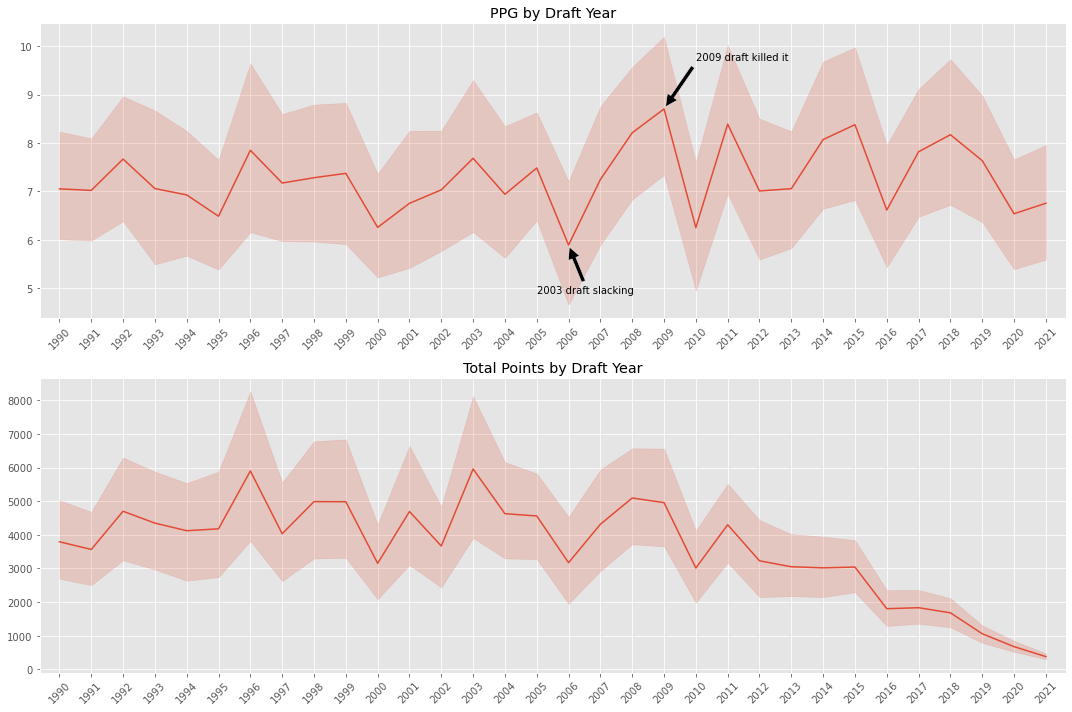

In [199]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 10))

ax = axes[0]
sns.lineplot(data=df, x='draft_year', y='pts_per_g', ax=ax)
xticks = df.index.get_level_values('draft_year').unique().sort_values()

ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45)
ax.set(title='PPG by Draft Year', xlabel='', ylabel='')

yearly_avg_ppg = df.groupby(df.index.get_level_values('draft_year')).pts_per_g.mean()
best_year = yearly_avg_ppg.nlargest(1)
xy = (best_year.index[0], best_year.values[0])
xytext = (xy[0] + 1, xy[1] + 1)
ax.annotate('2009 draft killed it', xy=xy, xytext=xytext, arrowprops=dict(facecolor='black', shrink=0.05))

yearly_avg_ppg = df.groupby(df.index.get_level_values('draft_year')).pts_per_g.mean()
best_year = yearly_avg_ppg.nsmallest(1)
xy = (best_year.index[0], best_year.values[0])
xytext = (xy[0] - 1, xy[1] - 1)
ax.annotate('2003 draft slacking', xy=xy, xytext=xytext, arrowprops=dict(facecolor='black', shrink=0.05))
ax.margins(x=0.02)

ax = axes[1]
sns.lineplot(data=df, x='draft_year', y='pts', ax=ax)
xticks = df.index.get_level_values('draft_year').unique().sort_values()
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45)
ax.set(title='Total Points by Draft Year', xlabel='', ylabel='')
ax.margins(x=0.02)


plt.tight_layout()
plt.show()

In [242]:
30 * 72 * 7 + df.loc[df.player == 'Stephen Curry', 'pts'].values[0]

35184.0

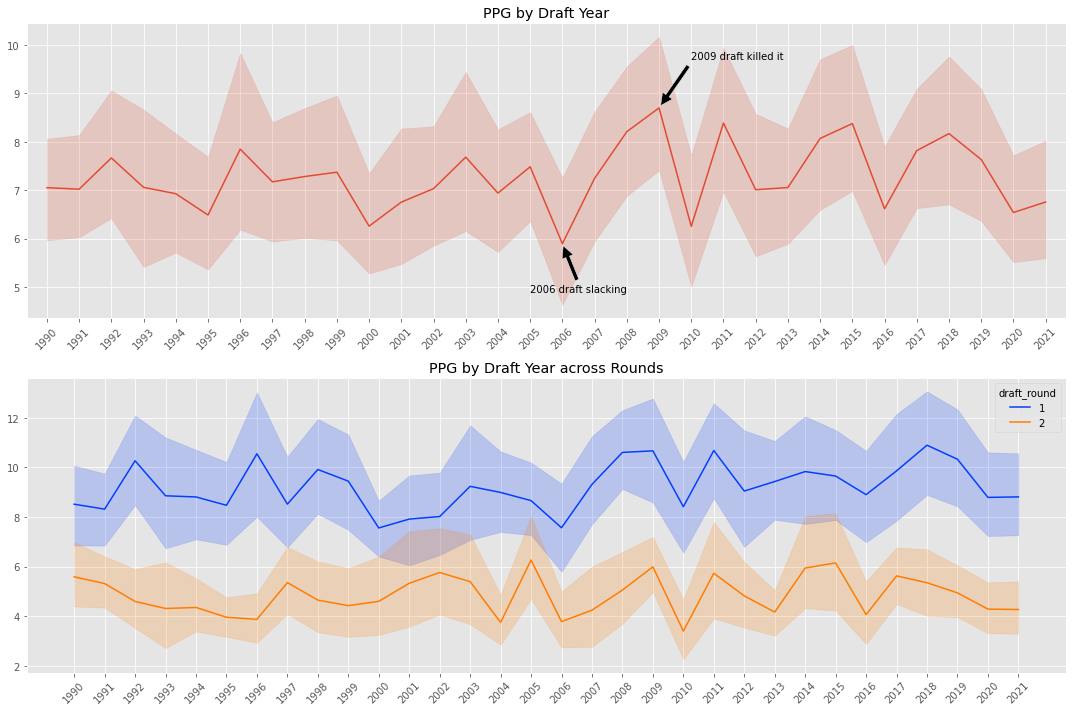

In [204]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 10))

ax = axes[0]
sns.lineplot(data=df, x='draft_year', y='pts_per_g', ax=ax)
xticks = df.index.get_level_values('draft_year').unique().sort_values()

ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45)
ax.set(title='PPG by Draft Year', xlabel='', ylabel='')

yearly_avg_ppg = df.groupby(df.index.get_level_values('draft_year')).pts_per_g.mean()
best_year = yearly_avg_ppg.nlargest(1)
xy = (best_year.index[0], best_year.values[0])
xytext = (xy[0] + 1, xy[1] + 1)
ax.annotate('2009 draft killed it', xy=xy, xytext=xytext, arrowprops=dict(facecolor='black', shrink=0.05))

yearly_avg_ppg = df.groupby(df.index.get_level_values('draft_year')).pts_per_g.mean()
worst_year = yearly_avg_ppg.nsmallest(1)
xy = (worst_year.index[0], worst_year.values[0])
xytext = (xy[0] - 1, xy[1] - 1)
ax.annotate('2006 draft slacking', xy=xy, xytext=xytext, arrowprops=dict(facecolor='black', shrink=0.05))
ax.margins(x=0.02)

ax = axes[1]
sns.lineplot(data=df, x='draft_year', y='pts_per_g', ax=ax, hue='draft_round', palette='bright')
xticks = df.index.get_level_values('draft_year').unique().sort_values()

ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45)
ax.set(title='PPG by Draft Year across Rounds', xlabel='', ylabel='')


plt.tight_layout()
plt.show()

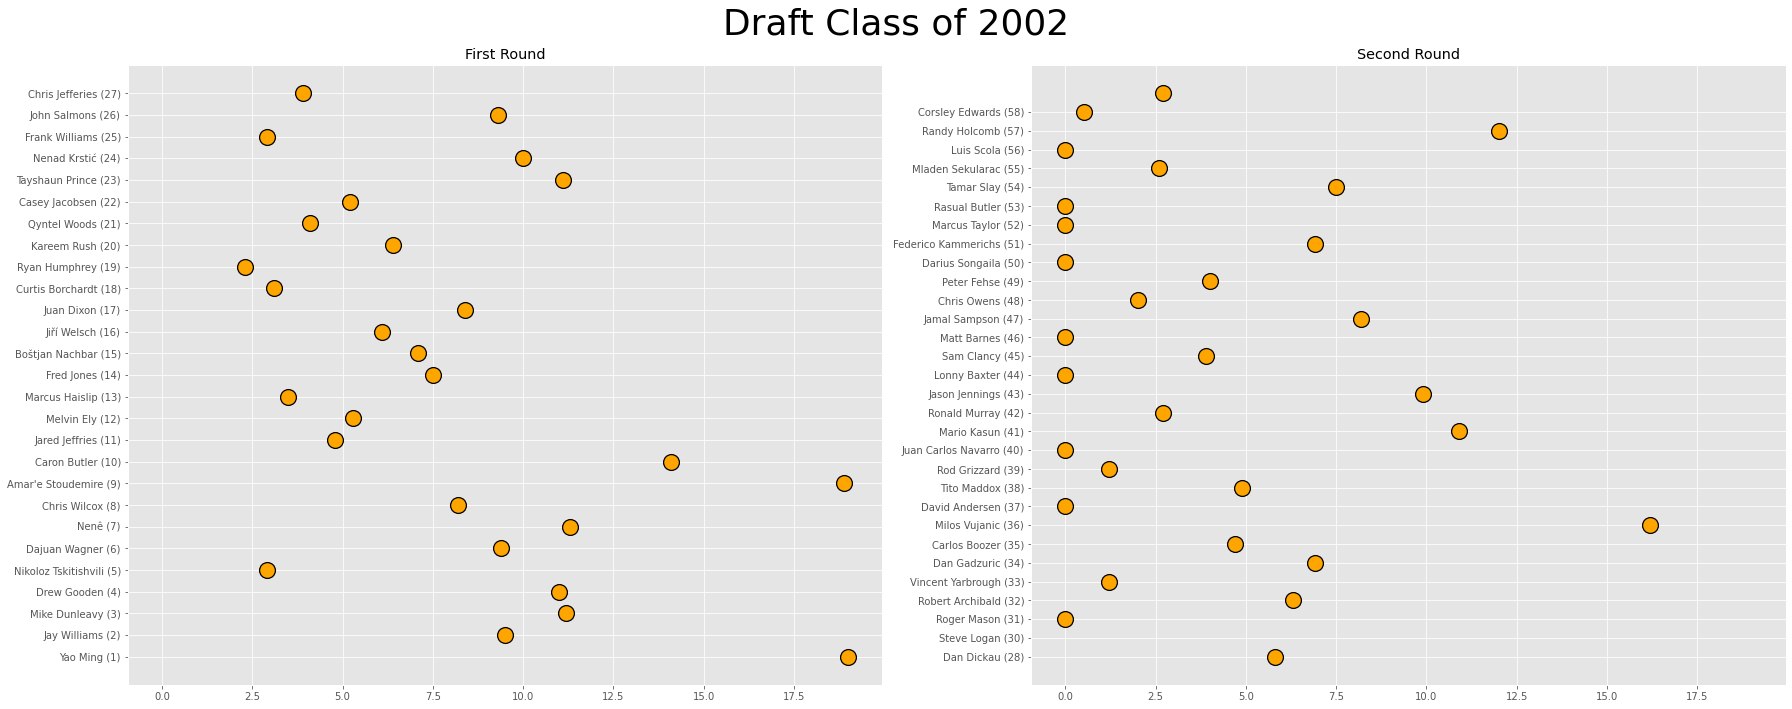

In [80]:
def draft_year_plot(year, show=True):
    fig, axes = plt.subplots(ncols=2, figsize=(25, 10), sharex=True)
    
    fig.suptitle(f'Draft Class of {year}', fontsize=36)

    ax = axes[0]
    data = df.loc[year, df.loc[:, 'draft_round'] == 1, :].fillna(0).reset_index()
    ax = sns.scatterplot(data=data, y='pick_overall', x='pts_per_g',
                         s=250, ax=ax, color='orange', edgecolor='black')
    labels = data.player + ' (' + data.pick_overall.map('{:.0f}'.format) + ')'
    ax.set_yticks(range(1, data.shape[0] + 1))
    ax.set_yticklabels(labels)
    ax.set(title='First Round', xlabel='', ylabel='')


    ax = axes[1]
    data = df.loc[year, df.loc[:, 'draft_round'] == 2, :].fillna(0).reset_index()
    ax = sns.scatterplot(data=data, y='pick_overall', x='pts_per_g',
                         s=250, ax=ax, color='orange', edgecolor='black')
    labels = data.player + ' (' + data.pick_overall.map('{:.0f}'.format) + ')'
    ax.set_yticks(range(data.pick_overall.min(), data.pick_overall.min() + data.shape[0]))
    ax.set_yticklabels(labels)
    ax.set(title='Second Round', xlabel='', ylabel='')
    plt.tight_layout()
    
    if show:
        plt.show(fig)
    else:
        return fig, ax
    
draft_year_plot(2002)

In [82]:
slider = widgets.IntSlider(
    min=df.index.get_level_values(0).min(), max=df.index.get_level_values(0).max(),
    step=1, description="Draft Year:", value= 2002
)
btn = widgets.Button(description="Show")
out = widgets.Output()
display(out)

@btn.on_click
def on_press(obj):
    with out:
        out.clear_output()
        draft_year_plot(slider.value)
        show_inline_matplotlib_plots()

display(slider, btn, output)

Output()

IntSlider(value=2002, description='Draft Year:', max=2021, min=1990)

Button(description='Show', style=ButtonStyle())

Output()

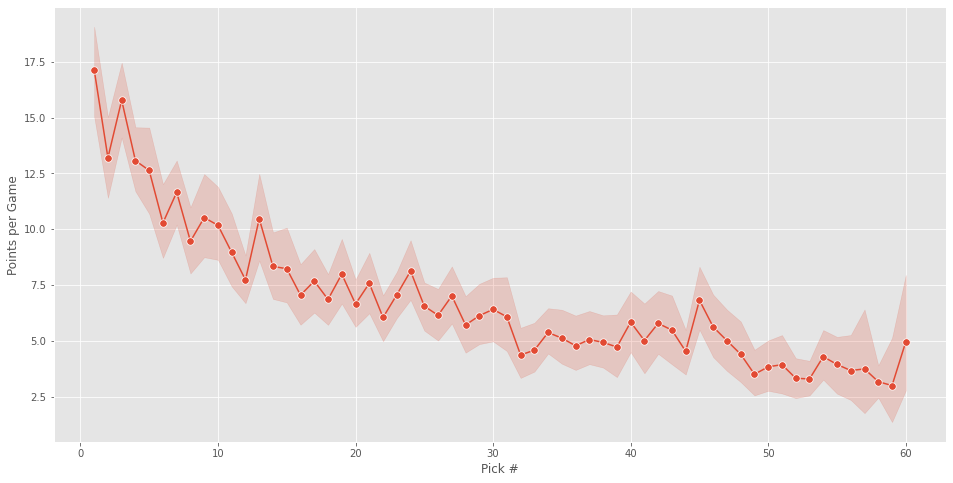

In [285]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(data=df, x='pick_overall', y='pts_per_g', ax=ax, marker='.', markersize=15)
ax.set(xlabel='Pick #', ylabel='Points per Game')
plt.show()

# By Position

# By School

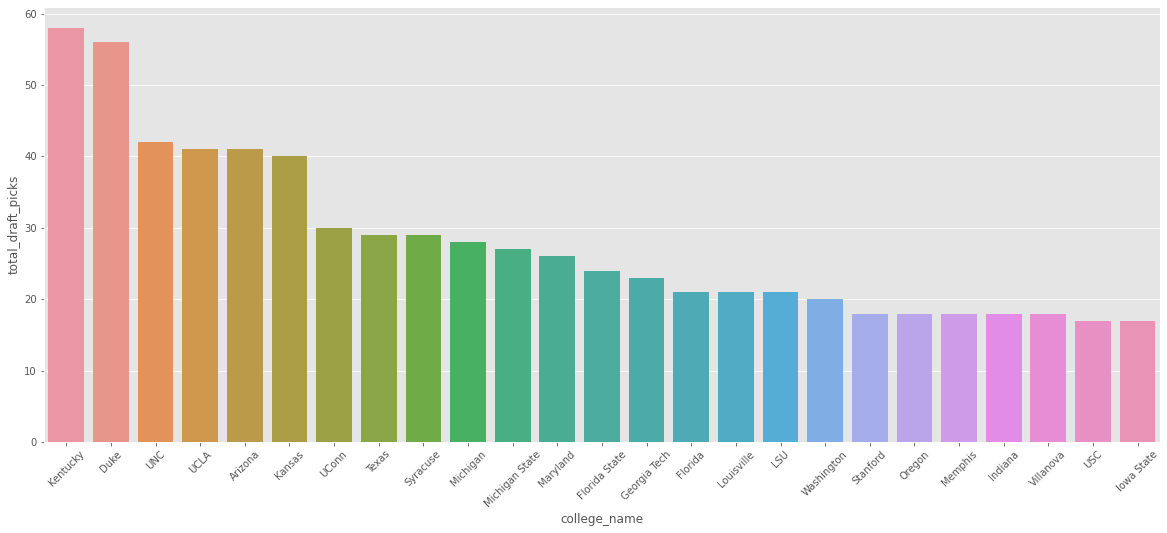

In [298]:
fig, ax = plt.subplots(figsize=(20, 8))
data = (pd.DataFrame(df.college_name.value_counts().nlargest(25))
        .reset_index()
        .rename(columns={'index': 'college_name', 'college_name': 'total_draft_picks'}))
sns.barplot(data=data, x='college_name', y='total_draft_picks')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

# Quick Regression

In [62]:
data = df.loc[~df.pts_per_g.isna(), ]
X, y = data.loc[:, ['pick_overall']], data.loc[:, ['pts_per_g']]
model = LinearRegression()
model.fit(X, y)
mean_squared_error(y, model.predict(y).reshape(-1, 1), squared=False)

6.67984918302736